In [1]:
import pandas as pd
from tqdm import tqdm
from score_card_model.ScoreCardModel import ScoreCardModel
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

In [2]:
df_train = pd.read_excel('./pycharm_project_179/data_source/train_data.xlsx')

In [3]:
df_train.shape
df_train.head()

(1000, 8)

,target,loan_amnt,funded_amnt,funded_amnt_inv,installment,dti,delinq_2yrs,inq_last_6mths
0,1,3829.037690,6.212097,10000,373.63,56.00,0,0
1,1,168.511277,7.610320,8000,246.40,22.23,0,0
2,1,449.911567,6.798086,20000,394.43,17.19,0,0
3,1,4560.199271,3.272754,16000,547.08,8.71,1,0
4,1,485.179886,9.568386,1000,39.17,22.85,0,1


In [4]:
df_train['target'].value_counts(normalize=True)

0    0.506
1    0.494
Name: target, dtype: float64

In [5]:
# 设定Y标名称
_target = 'target'

# eda是否有类别型特征
for col in df_train.columns.drop(_target):
    if df_train[col].dtype == 'O':
        print(col)
        
# 设置特殊值分布
sp_vals_cols = {}
for col in tqdm(df_train.columns.drop(_target)):
    if df_train[col].dtype == 'O':
        if '-1' in set(df_train[col]):
            sp_vals_cols[col] = ['-1']
    else:
        if -1 in set(df_train[col]):
            sp_vals_cols[col] = [-1]

100%|██████████| 7/7 [00:00<00:00, 6386.80it/s]


In [6]:
# sp_vals_cols, 特殊值字典, 格式为{'特征名':[特征值]}
#PS:注意,当前的版本仅支持数值类以-1作为特殊值,且数值型特征必须大于等于0(有时间再修改)
#有序型类别特征不支持存在空值, 建议做label encoding后, 再以-1作为特殊值输入

# const_cols_ratio, 判断常值特征的阈值
# max_intervals, 最大分箱数(含特殊值箱, 特殊值单独成箱)
# min_pnt, 分箱的最小样本数占比
# idx_cols_disc_ord, 有序离散特征及其排序idx
pipe_config = {'sp_vals_cols': sp_vals_cols,
               'const_cols_ratio': 0.9,
               'max_intervals': 5,
               'min_pnt': 0.02,
               'idx_cols_disc_ord': {}}

In [7]:
# 初始化模型类
scm_obj = ScoreCardModel(target=_target)

In [8]:
# 建立pineline, 这里开始会自己分箱
scm_obj.model_pineline_proc(df=df_train, pipe_config=pipe_config)

Checking None values: No None value exists.


Cutting discrete features: 0it [00:00, ?it/s]
Cutting continuous features: 100%|██████████| 7/7 [01:29<00:00, 12.74s/it]


In [9]:
# 获取流水线处理列表
print(scm_obj.pinelines)

[(0, 'Check_Target'), (1, 'Check_None'), (2, 'Check_Const_Cols'), (3, 'Check_Cols_Types'), (4, 'Add_Mono_Expect'), (5, 'Chi2_Cutting')]


In [10]:
# 获取所有特征的分组取值
scm_obj.dict_cols_to_bins

{'loan_amnt': {'(-1,6019.6344]': 0, '(6019.6344,+Inf)': 1},
 'funded_amnt': {'(-1,1.8505]': 0, '(1.8505,8.6595]': 1, '(8.6595,+Inf)': 2},
 'funded_amnt_inv': {'(-1,8200.0000]': 0, '(8200.0000,+Inf)': 1},
 'installment': {'(-1,696.2800]': 0, '(696.2800,+Inf)': 1},
 'dti': {-1: 0, '(-1,6.9800]': 1, '(6.9800,+Inf)': 2},
 'delinq_2yrs': {'(-1,4.5000]': 0, '(4.5000,+Inf)': 1},
 'inq_last_6mths': {'(-1,2.5000]': 0, '(2.5000,+Inf)': 1}}

In [11]:
# 获取所有特征的IV
scm_obj.dict_iv

{'loan_amnt': 0.02286340407868949,
 'funded_amnt': 0.010006882750089898,
 'funded_amnt_inv': 0.021796836875907832,
 'installment': 0.008190045792572029,
 'dti': 0.009994371668505503,
 'delinq_2yrs': 0.000680561334768973,
 'inq_last_6mths': 0.0026257736331374384}

In [12]:
# 获取所有特征的woe值
scm_obj.dict_woe

{'loan_amnt': {0: 0.07697696807730701, 1: -0.2975824720279192},
 'funded_amnt': {0: -0.16604245078832194,
  1: 0.00918606631440247,
  2: 0.1873262082028426},
 'funded_amnt_inv': {0: 0.25426217118261674, 1: -0.08588170026509391},
 'installment': {0: 0.043754880835775584, 1: -0.18730794156766395},
 'dti': {1: -0.30847040707271983,
  2: 0.03243642661635889,
  0: 0.02800182954849292},
 'delinq_2yrs': {0: -0.0021836268955238653, 1: 0.31168322455132397},
 'inq_last_6mths': {0: 0.007640868994336085, 1: -0.34372362802577444}}

In [13]:
# 生成woe转化后的dataframe, 这里方便演示, train_和test同集合
df_woe_train = scm_obj.trans_df_to_woe(df=df_train)
df_woe_train.shape
df_woe_train.head()

transforming the woe dataframe: 100%|██████████| 8/8 [00:00<00:00, 1295.84it/s]


(1000, 8)

,loan_amnt,funded_amnt,funded_amnt_inv,installment,dti,delinq_2yrs,inq_last_6mths,target
0,0.076977,0.009186,-0.085882,0.043755,0.032436,-0.002184,0.007641,1
1,0.076977,0.009186,0.254262,0.043755,0.032436,-0.002184,0.007641,1
2,0.076977,0.009186,-0.085882,0.043755,0.032436,-0.002184,0.007641,1
3,0.076977,0.009186,-0.085882,0.043755,0.032436,-0.002184,0.007641,1
4,0.076977,0.187326,0.254262,0.043755,0.032436,-0.002184,0.007641,1


In [14]:
df_woe_test = scm_obj.trans_df_to_woe(df=df_train)
df_woe_test.shape
df_woe_test.head()

transforming the woe dataframe: 100%|██████████| 8/8 [00:00<00:00, 1338.43it/s]


(1000, 8)

,loan_amnt,funded_amnt,funded_amnt_inv,installment,dti,delinq_2yrs,inq_last_6mths,target
0,0.076977,0.009186,-0.085882,0.043755,0.032436,-0.002184,0.007641,1
1,0.076977,0.009186,0.254262,0.043755,0.032436,-0.002184,0.007641,1
2,0.076977,0.009186,-0.085882,0.043755,0.032436,-0.002184,0.007641,1
3,0.076977,0.009186,-0.085882,0.043755,0.032436,-0.002184,0.007641,1
4,0.076977,0.187326,0.254262,0.043755,0.032436,-0.002184,0.007641,1


In [15]:
# 以下筛选过程顺序可以随意安排, 也非必须调用的内容, 筛选出来后可自由drop
## 基于iv进行特征筛选
cols_iv_lower = scm_obj.filter_df_woe_iv(iv_thres=0.02)
print('IV drop:{0}'.format(cols_iv_lower))

## 基于相关系数进行特征筛选
cols_corr_higher = scm_obj.filter_df_woe_corr(df_woe=df_woe_train, corr_thres=0.7)
print('Corr drop:{0}'.format(cols_corr_higher))

## 基于膨胀因子进行特征筛选
cols_vif_higher = scm_obj.filter_df_woe_vif(df_woe=df_woe_train, vif_thres=10, frac=0.5)
print('VIF drop:{0}'.format(cols_vif_higher))

# 基于显著性进行特征筛选
cols_pval_higher = scm_obj.filter_df_woe_pvalue(df_woe=df_woe_train, pval_thres=0.05, frac=0.5)
print('P value drop:{0}'.format(cols_pval_higher))

IV drop:{'dti', 'funded_amnt', 'installment', 'delinq_2yrs', 'inq_last_6mths'}
Corr drop:set()


combinations, n=7: 1it [00:00, 92.92it/s]


VIF drop:[]


combinations, n=7: 1it [00:00, 72.80it/s]
combinations, n=6: 7it [00:00, 56.93it/s]
combinations, n=5: 21it [00:00, 59.26it/s]
combinations, n=4: 35it [00:00, 61.93it/s]
combinations, n=3: 35it [00:00, 58.37it/s]
combinations, n=2: 21it [00:00, 121.71it/s]
combinations, n=1: 7it [00:00, 124.39it/s]

P value drop:['loan_amnt', 'funded_amnt_inv', 'installment', 'dti', 'delinq_2yrs', 'inq_last_6mths']


In [16]:
# 也可以直接暴力搜索
model_res = scm_obj.search_best_feats(df_woe=df_woe_train, n_start=5, n_end=3)
pd.DataFrame(model_res)

combinations, n=5: 21it [00:00, 31.05it/s]
combinations, n=4: 35it [00:00, 45.10it/s]
combinations, n=3: 35it [00:00, 51.92it/s]


""


In [17]:
# 确定入模特征
md_feats = df_woe_train.columns.drop(scm_obj.target).tolist()

scm_obj.set_md_features(md_feats=md_feats, df_woe=df_woe_train)

设置入模特征7个.


In [18]:
# 检查一下系数
scm_obj._coefs

{'const': -0.02386332164605525,
 'loan_amnt': 0.6536646334278194,
 'funded_amnt': 0.7493698960650444,
 'funded_amnt_inv': 0.6658913271068946,
 'installment': 0.22176303724493338,
 'dti': 0.7165663028614507,
 'delinq_2yrs': 0.1745610376847926,
 'inq_last_6mths': 0.33428673278830107}

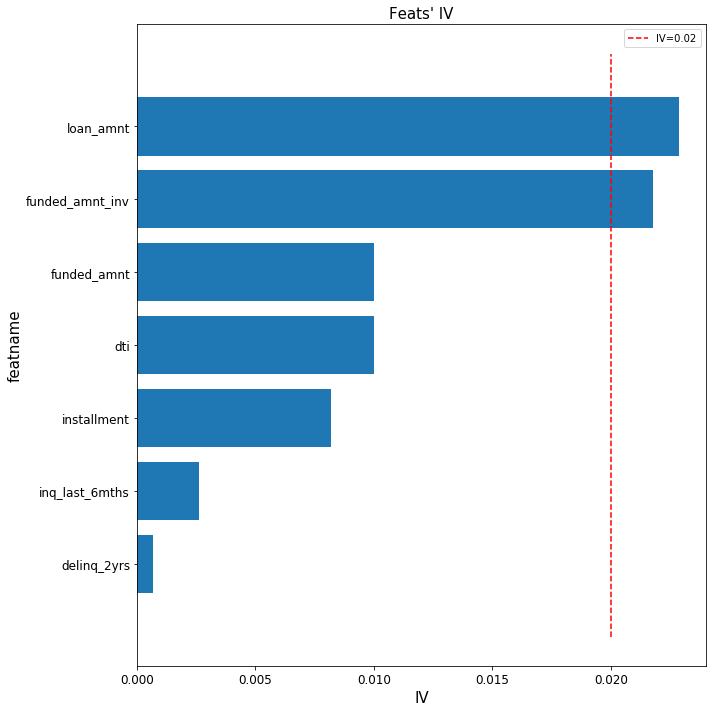

In [19]:
# 入模iv值绘图
scm_obj.plot_feats_iv(feats=md_feats)

In [20]:
# 成入模变量的单箱分数表, 最终用于业务使用, 当前路径下也会生成个Score_bins.xlsx文件
scm_obj.gen_feat_to_score(md_feats=md_feats)

,featname,value,group_no,group_woe,group_score,const_score,iv
0,loan_amnt,"(-1,6019.6344]",0,0.076977,-1,500,0.022863
1,loan_amnt,"(6019.6344,+Inf)",1,-0.297582,6,500,0.022863
2,funded_amnt,"(-1,1.8505]",0,-0.166042,4,500,0.010007
3,funded_amnt,"(1.8505,8.6595]",1,0.009186,0,500,0.010007
4,funded_amnt,"(8.6595,+Inf)",2,0.187326,-4,500,0.010007
5,funded_amnt_inv,"(-1,8200.0000]",0,0.254262,-5,500,0.021797
6,funded_amnt_inv,"(8200.0000,+Inf)",1,-0.085882,2,500,0.021797
7,installment,"(-1,696.2800]",0,0.043755,0,500,0.008190
8,installment,"(696.2800,+Inf)",1,-0.187308,1,500,0.008190
9,dti,-1,0,0.028002,-1,500,0.009994


In [21]:
# 这里是对任意的dataframe进行编码, 比如对训练集进行编码
df_woe_train = scm_obj.trans_df_to_woe(df=df_train)

df_woe_train.shape
df_woe_train.head()

transforming the woe dataframe: 100%|██████████| 8/8 [00:00<00:00, 1460.54it/s]


(1000, 8)

,loan_amnt,funded_amnt,funded_amnt_inv,installment,dti,delinq_2yrs,inq_last_6mths,target
0,0.076977,0.009186,-0.085882,0.043755,0.032436,-0.002184,0.007641,1
1,0.076977,0.009186,0.254262,0.043755,0.032436,-0.002184,0.007641,1
2,0.076977,0.009186,-0.085882,0.043755,0.032436,-0.002184,0.007641,1
3,0.076977,0.009186,-0.085882,0.043755,0.032436,-0.002184,0.007641,1
4,0.076977,0.187326,0.254262,0.043755,0.032436,-0.002184,0.007641,1


In [22]:
# 获取分数列表,注意这个地方必须要包含所有的入模特征
y_proba, scores = scm_obj.get_df_scores(df_woe=df_woe_train)
y_true = df_woe_train[_target]

In [23]:
# 保存模型
scm_obj.save_model()

# Badrate EDA

cutting bins: 100%|██████████| 2/2 [00:00<00:00, 509.54it/s]


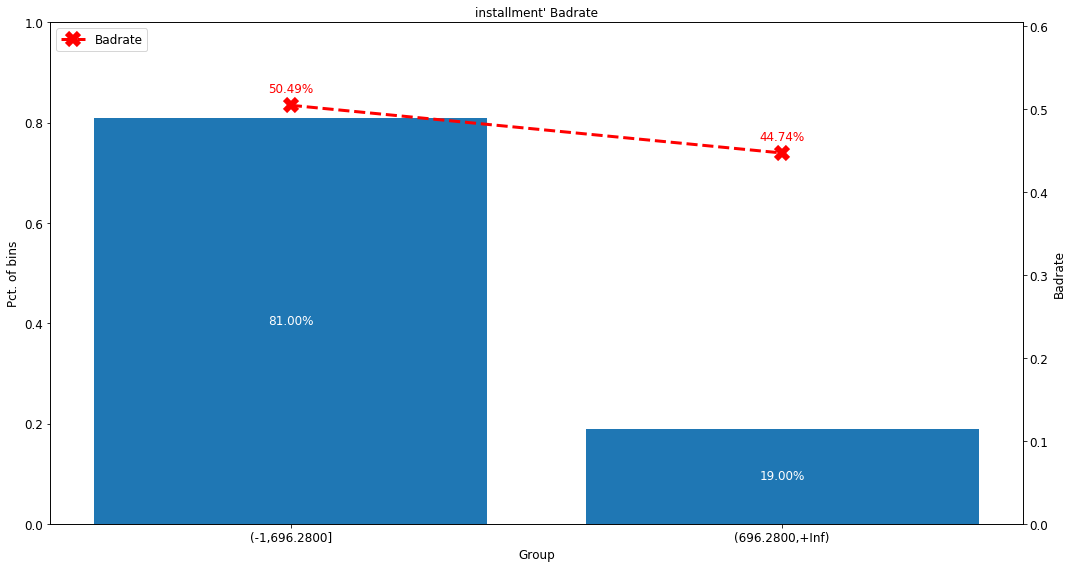

In [24]:
#factor为控制字体、画布大小的倍数因子, 因为入模特征不可知, 所以留了这个参数提供自己调节
scm_obj.plot_feats_badrate(df=df_train.loc[:, ['installment', _target] ], factor=1)

# 模型评估

In [25]:
import  random
import numpy as np

# 用两个正态分布随机数模拟分数的分布
n_train, mu_train, sigma_train = 500, 480, 100
y_true_train = [random.randint(0,1) for i in range(n_train)]
y_pred_train = [random.randint(0,1) for i in range(n_train)]
y_proba_train = [random.random() for i in range(n_train)]
score_train = np.random.normal(mu_train, sigma_train, n_train)

n_test, mu_test, sigma_test = 1000, 420, 100
y_true_test = [random.randint(0,1) for i in range(n_test)]
y_pred_test = [random.randint(0,1) for i in range(n_test)]
y_proba_test = [random.random() for i in range(n_test)]
score_test = np.random.normal(mu_test, sigma_test, n_test)

0.5016741697239623

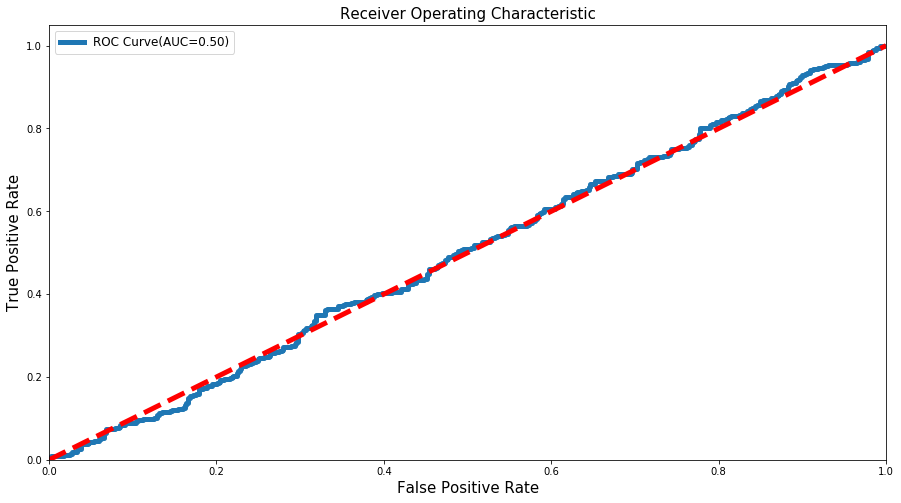

In [26]:
# ROC
from score_card_model.utils import model_roc_auc

model_roc_auc(y_true=y_true_test, y_proba=y_proba_test, is_plot=True)

0.05828039237650218

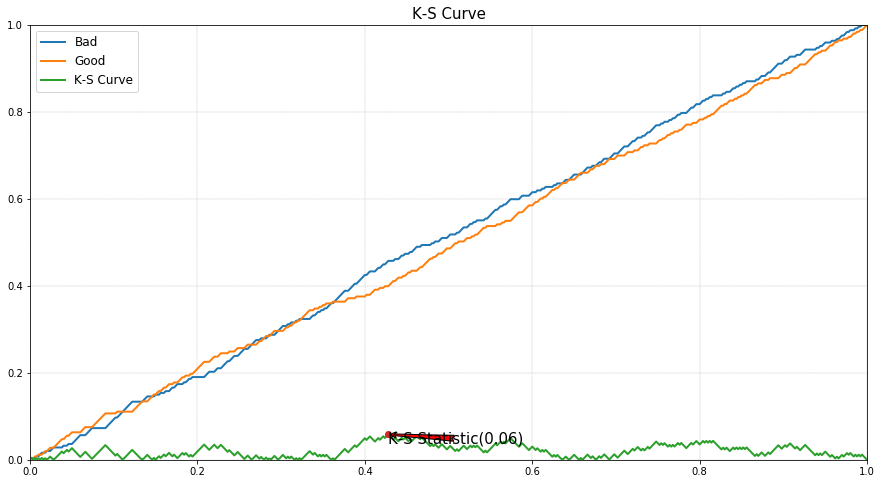

In [27]:
# KS
from score_card_model.utils import model_ks

model_ks(y_true=y_true_train, y_pred=y_pred_train, y_proba=y_proba_train, is_plot=True)

0.013595141700404767

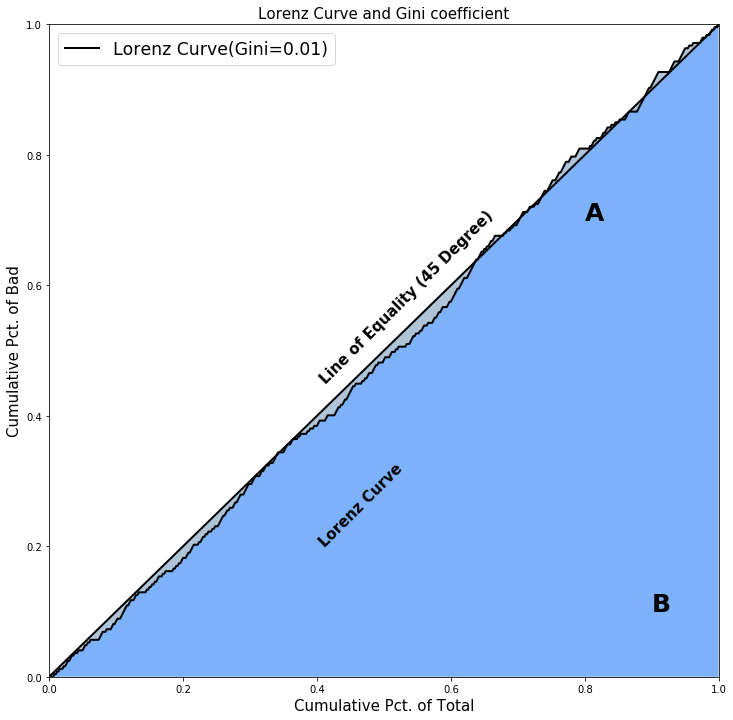

In [28]:
# Gini系数和Lorenz曲线:
from score_card_model.utils import model_gini

model_gini(y_true=y_true_train, y_proba=y_proba_train, is_plot=True)

In [29]:
# 计算psi以及其分箱分布
from score_card_model.utils import model_psi

psi, df_psi = model_psi(score_train=score_train, score_test=score_test)
psi
df_psi

0.3801272195492671

,score_groupno,score_interval,actual_pnt,expected_pnt,diff_ac_exp_pnt,div_ac_exp_pnt,ln_ac_exp_pnt,index
0,0,"[0,212)",0.006,1.700000e-02,-0.011,3.529412e-01,-1.041454,0.011456
1,1,"[212,281)",0.036,6.000000e-02,-0.024,6.000000e-01,-0.510826,0.012260
2,2,"[281,350)",0.062,1.560000e-01,-0.094,3.974359e-01,-0.922722,0.086736
3,3,"[350,419)",0.154,2.570000e-01,-0.103,5.992218e-01,-0.512123,0.052749
4,4,"[419,488)",0.258,2.450000e-01,0.013,1.053061e+00,0.051701,0.000672
5,5,"[488,557)",0.254,1.660000e-01,0.088,1.530120e+00,0.425346,0.037430
6,6,"[557,626)",0.140,7.700000e-02,0.063,1.818182e+00,0.597837,0.037664
7,7,"[626,695)",0.068,2.100000e-02,0.047,3.238095e+00,1.174985,0.055224
8,8,"[695,764)",0.020,1.000000e-03,0.019,2.000000e+01,2.995732,0.056919
9,9,"[764, +Inf)",0.002,1.000000e-09,0.002,2.000000e+06,14.508658,0.029017


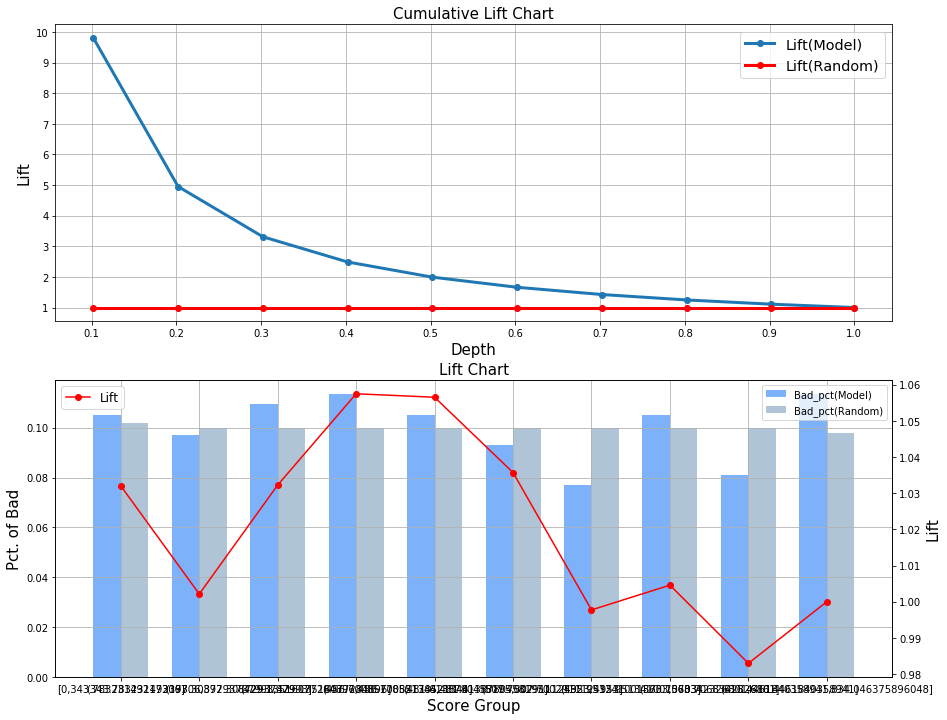

In [30]:
# LIFT
from score_card_model.utils import model_lift

df = model_lift(y_true=y_true_train, y_score=score_train, is_plot=True)

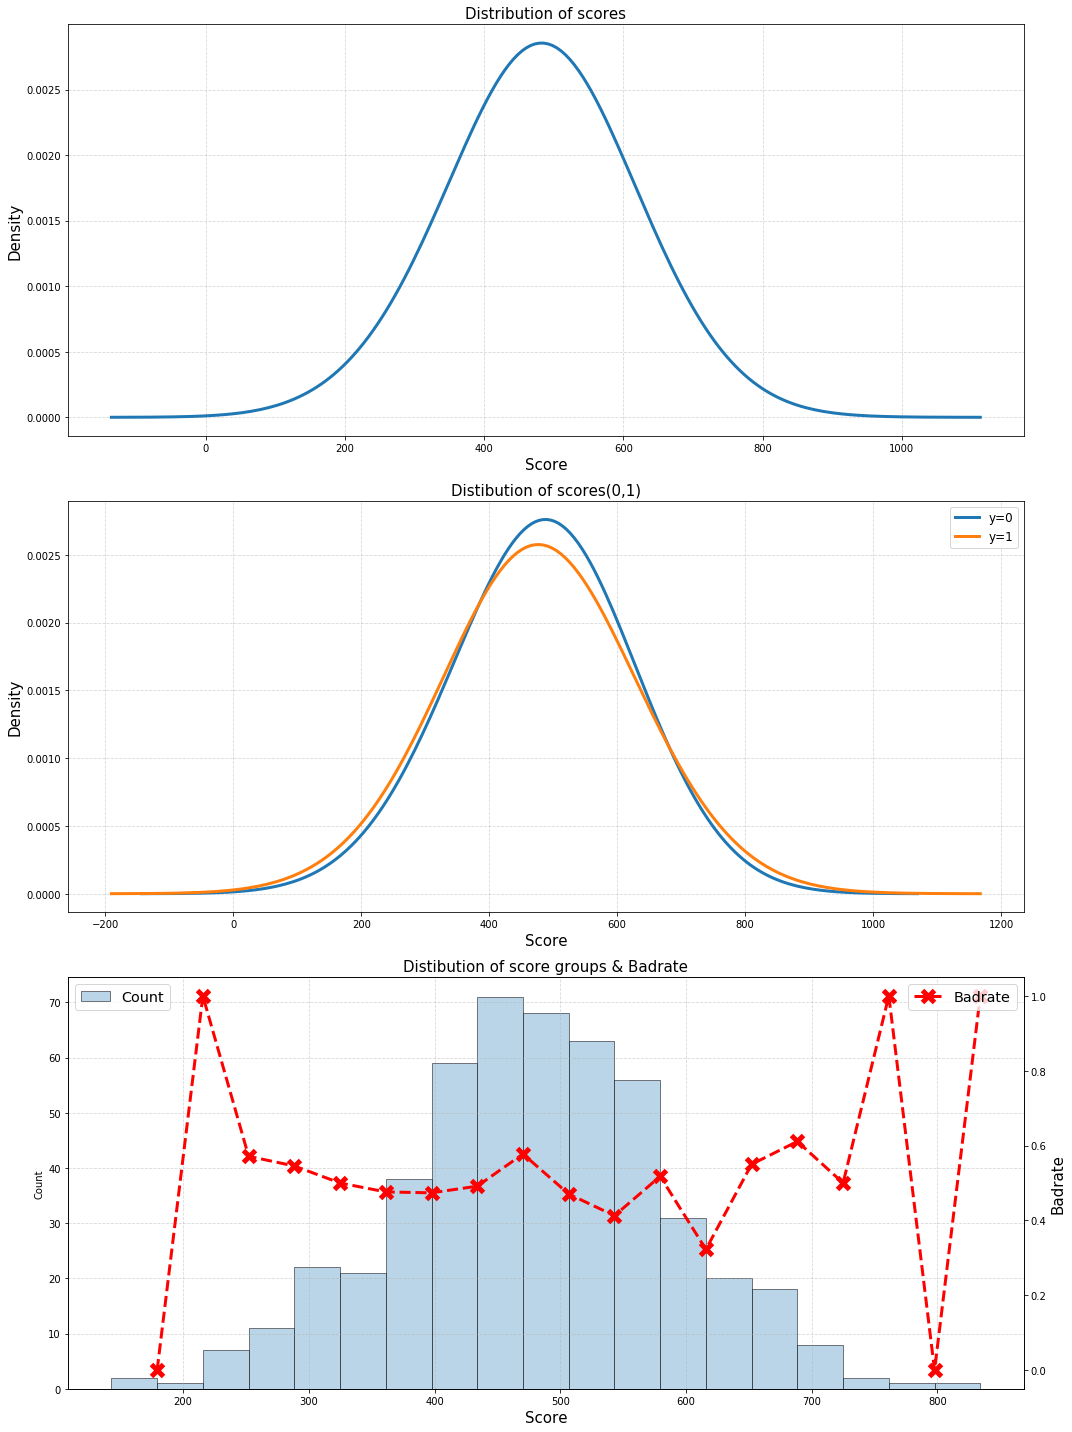

In [31]:
# score分数:
from score_card_model.utils import plot_score_distribution


# 实际应用中大多score只是近似正态，这个时候可以通过调大bw_adjust来使得平滑
plot_score_distribution(y=y_true_train, score=score_train, dict_plot_params = {'bw_adjust': 3})